In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
def fx_fun(xi):
    from numpy import asarray
    x1=xi[0]
    x2=xi[1]
    #y= -(2*xi[0]+3*xi[1]-xi[0]**3-2*xi[1]**2);
    #y=0.5*xi[0]**2+xi[1]**2-xi[0]*xi[1]-7*xi[0]-7*xi[1];
    y=10*x1**4-(20*x1**2)*x2+10*x2**2+x1**2-2*x1+5
    dydx1=40*x1**3 - 40*x1*x2 + 2*x1 - 22;
    dydx2=-20*x1**2 + 20*x2;
    df= asarray([dydx1,dydx2])
    return y,df

In [50]:
def gx_fun(x):
    from numpy import transpose
    x1=x[0]
    x2=x[1]
    g1=-2-x1
    g2=x1-0.5
    g3=-0.5-x2
    g4=x2-4.5
    g=[g1,g2,g3,g4]
    dg1dx=[-1, 1, 0, 0]
    dg2dx=[0, 0, -1, 1]
    dg=transpose([dg1dx,dg2dx])
    h=[]
    dh=[]
    return g,dg#,h,dh

In [55]:
def SLP(fx_fun,gx_fun):
    import time
    import matplotlib.pyplot as plt
    from numpy import arange,meshgrid,zeros,matrix,asarray,transpose,amax,amin,ones,dot,linalg,append
    from scipy.optimize import linprog
    from matplotlib.pyplot import xlim,ylim,legend,title,xlabel,ylabel
    start=time.perf_counter()
    xs1=arange(-3.5,4.5,.1)
    [x1,x2]=meshgrid(xs1,xs1)
    a=len(x1)
    b=len(x2)
    f=zeros([a,b])
    g1=zeros([a,b])
    g2=zeros([a,b])
    g3=zeros([a,b])
    g4=zeros([a,b])

    for i in range(a):
        for j in range(b):
            xi=[x1[i,j],x2[i,j]]
            #print("xi:"+str(xi))#really big if unsupressed
            fk,dfk=fx_fun(xi)
            gk,dgk=gx_fun(xi)
            f[i,j]=fk
            g1[i,j]=gk[0]
            g2[i,j]=gk[1]
            g3[i,j]=gk[2]
            g4[i,j]=gk[3]
    fig,ax=plt.subplots()
    CS=ax.contour(x1,x2,f,levels=[4.275,4.6,5,7.5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150],cmap='turbo')#levels=[4.6,5,7.5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]
    colorbar=plt.colorbar(CS)
    colorbar.set_label("Objective Function Value",fontsize=24)
    #ax.clabel(CS,CS.levels,inline=False,fontsize=12)
    cv1=asarray([0.001, 0.0011])
    cv1=cv1*amax(g1)
    ax.contour(x1,x2,g1,cv1,cmap='Greys')
    cv2=asarray([0.001, 0.0011])*amax(g2)
    ax.contour(x1,x2,g2,cv2,cmap='Greys')
    cv3=asarray([0.001, 0.0015])*amax(g3)
    ax.contour(x1,x2,g3,cv3,cmap='Greys')
    cv4=asarray([0.05, 0.0499])*amin(g4)
    ax.contour(x1,x2,g4,cv4,cmap='Greys')
    fig.set_size_inches(14*1.5, 9*1.5) 
    xlim([-2.5,1])
    ylim([-1,4.25])
    DVn=2
    xk=transpose([-1,3.5])
    tol=.0001
    k=0
    iterN=int(0)
    iter_x_history=[]
    iter_y_history=[]
    iter_g_history=[]

    ML=.1
    old_dxp=xk
    #print("xk:"+str(xk))
    c=.5

    while 1:


        iterN=iterN+1
        fk,dfk=fx_fun(xk)
        gk,dgk=gx_fun(xk)
        #print("fk:"+str(fk))
        #print("dfk:"+str(dfk))
        #print("gk:"+str(gk))
        #print("dgk:"+str(dgk))

        iter_x_history=append(iter_x_history,xk[0])
        iter_y_history=append(iter_y_history,xk[1])
        iter_g_history=append(iter_g_history,gk)
        #scatter3 from matlab code not here because of matplotlib loop plotting issue encountered values are instead stored then plotted after while loop.
        ci=asarray(dfk)
        A=asarray(dgk)
        b=-asarray(gk)
        #print("ci:"+str(ci))
        #print("A:"+str(A))
        #print("b:"+str(b))

        if ML<tol or iterN>100:
            stop=time.perf_counter()
            break
        bound1=(-.1,.1)
        #print("bound1:"+str(bound1))
        bound2=(-.1,.1)
        #print("bound2:"+str(bound2))
        res=linprog(ci,A_ub=A,b_ub=b,\
                    method='revised simplex',bounds=(bound1,bound2))#,options={"disp":True})
        #print("res:"+str(res))
        #break
        dxp=res["x"]
        fval=res["fun"]
        #print("fval:"+str(fval))
        #print("dxp:"+str(dxp))
        xlp=xk+dxp
        xk=xlp[:]
        #print("xk:"+str(xk))
        angle=dot(old_dxp,dxp)/linalg.norm(old_dxp)*linalg.norm(dxp)
        #print("angle:"+str(angle))

        if angle<-.8:
            ML=ML*c

    elapsed=stop-start
    #print(str(elapsed)+" seconds calculation time");
    f_opt=fx_fun([xk[0],xk[1]])
    #print(f_opt[0])
    #print(iter_x_history)        
    ax.scatter(iter_x_history,iter_y_history,color='blue')
    ax.plot(iter_x_history,iter_y_history,color='grey',label='Search Path')
    ax.scatter(iter_x_history[0],iter_y_history[0],color='green',label='Starting $x_k$')
    ax.scatter(xk[0],xk[1],color='red',label='Optimum Design Point: ['+str(xk[0])+", "+str(round(xk[1],5))+'] at f='+str(round(f_opt[0],5))+'\nConverged after: '+str(iterN)+' loops and '+str(round(elapsed,4))+' seconds')
    legend(loc=3,fontsize=24)
    title("Sequential Linear Programming Method Python Implementation",fontsize=24,pad=10)
    xlabel("$x_1$ value",fontsize=24)
    ylabel("$x_2$ value",fontsize=24);
    #print(iter_x_history)
    #print(iter_y_history)
    #print("xk:"+str(xk))
    xk_final=[xk[0],xk[1]]
    return f_opt,xk_final

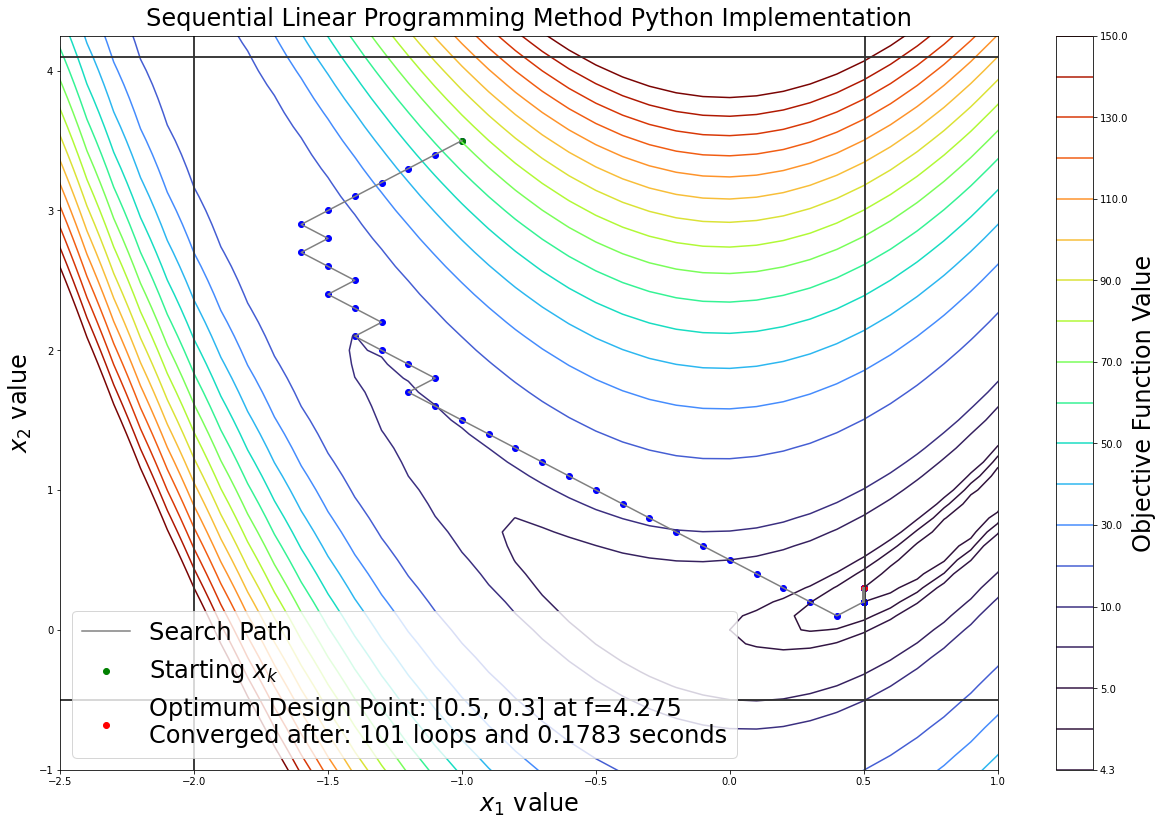

In [56]:
SLP(fx_fun,gx_fun);